# Configurações iniciais

In [12]:
# LIBS
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
import re
import warnings 
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings('ignore') 
import seaborn as sns
import joblib

# CONFIGURAÇÕES

pd.set_option('display.max_rows',100) # Ajustando número máximo de linhas a serem exibidas por dataframes
pd.set_option('display.max_columns',100) # Ajustando número máximo de colunas a serem exibidas por dataframes
pd.set_option('display.width', 100) # Ajustando tamanho a ser exibido dos valores do dataframe
pd.set_option('display.float_format', lambda x: '%.4f' % x) # Ajustando o valor dos valores floats para 4 casas decimais
%config InlineBackend.figure_format = 'retina' # Ajustando a nitidez dos gráficos
SEED = 27 # Semente para reprodução de pseudo-aleatoriedade

# DIRETÓRIOS

project_data_path = '../data' # Diretório da base de dados
model_path = '../model' # Diretório para o modelo
src_path = '../transformers' 
sys.path.insert(0, src_path)

from transformers import CombineTextColumns, CustomImputer, FullTextPreprocessor

# Preparando a base

In [13]:
# Aqui faço a leitura da base de dados a partir da variável 'project_data_path', na pasta 'raw' e o arquivo 'Travel_Chalenge.csv'

df = pd.read_csv(os.path.join(project_data_path, 'raw', 'Travel_Chalenge.csv'), sep = ';')
df.sample(3) # Uma amostra aleatória de 3 registros dos dados

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
9281,Singapore Airlines,1,"""maybe the best experience""",24th November 2022,SQ23 in Premium Economy Solo Seat. 1730 Arr...,A350-900ULR,Solo Leisure,Premium Economy,New York to Singapore,November 2022,5.0000,5.0000,5.0000,5.0000,5.0000,NaN
14295,FlySafair,4,"""Crew weren't helpful at all""",3rd September 2019,Cape Town to Durban. Had a bit of a struggle...,NaN,Solo Leisure,Economy Class,Cape Town to Durban,August 2019,2.0000,2.0000,NaN,2.0000,NaN,NaN
2523,Lynx Air,1,"""Emails have gone unanswered""",14th July 2023,"I'd rate Lynx a ""0"" if that were an option. ...",NaN,Solo Leisure,Economy Class,Calgary to Winnipeg,May 2023,1.0000,1.0000,NaN,1.0000,NaN,NaN


## Variável Target

In [14]:
# Tratando variável de interesse
df.loc[df['Overall_Rating'] == 'n', 'Overall_Rating'] = int(df.loc[df['Overall_Rating'] != 'n', 'Overall_Rating'].astype(int).median())
df['Overall_Rating'] = df['Overall_Rating'].astype(int)

In [15]:
# Criando classe de sentimentos para modelagem

def rules(rating):
    if rating < 4:
        return 'negative'
    elif rating >= 4 and rating <= 7:
        return 'neutral'
    else:
        return 'positive'
    
def encode_rules(class_col):
    if class_col == 'negative':
        return 0
    elif class_col == 'neutral':
        return 1
    elif class_col == 'positive':
        return 2


df.insert(2, 'Status', df['Overall_Rating'].apply(rules))
df.insert(3, 'Class', df['Status'].apply(encode_rules))

df.sample(3)

,Airline Name,Overall_Rating,Status,Class,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
16478,Ethiopian Airlines,9,positive,2,"""A very enjoyable flight""",7th May 2023,This was the first time I used this airline ...,9,Solo Leisure,Economy Class,Heathrow to Madagascar via Addis Dabba,May 2023,4.0000,5.0000,5.0000,5.0000,4.0000,4.0000
5626,US Airways,1,negative,0,US Airways customer review,19th March 2015,Traveled from Omaha to Honolulu with 4 connect...,NaN,NaN,Economy Class,NaN,NaN,2.0000,2.0000,3.0000,NaN,2.0000,NaN
1740,Kuwait Airways,9,positive,2,"""I would recommend""",13th April 2019,We found the best option to go to Istanbul f...,Boeing 777-300ER / A320,Family Leisure,Economy Class,Bengaluru to Istanbul via Kuwait,March 2019,4.0000,4.0000,5.0000,4.0000,4.0000,3.0000


In [16]:
df['Class'].value_counts() # Variável de interesse desbalanceada

Class
0    12622
2     2545
1     2535
Name: count, dtype: int64

## Colunas de texto

In [17]:
def clean_text(text):
    # Converte o texto para minúsculas
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove menções (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove pontuações e caracteres especiais (exceto espaços)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove números
    text = re.sub(r'\d+', '', text)
    
    # Remove múltiplos espaços em branco
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# Removendo stopwords utilizando o idioma Inglês
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])


# Redução de palavras usando lemmatização
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Removendo emojis
def remove_emojis(text):
    return text.encode('ascii', 'ignore').decode('ascii')

# Considerando que a palavra 'not' pode inverter o sentido 
# Como por exemplo: "I absolutely loooove this product! It's not bad at all 😊",
# Nos casos de uso da palavra 'not', a função marca a próxima palavra e junta como uma única expressão, 
# Exemplo: 'not good' => 'not_good' 

def handle_negation(text):
    negation = "not"
    words = text.split()
    negated_sentence = []
    negate = False
    
    for word in words:
        if word == negation:
            negate = True
        elif negate:
            negated_sentence.append(f"not_{word}")
            negate = False
        else:
            negated_sentence.append(word)
    
    return ' '.join(negated_sentence)


def preprocess_text(text):
    text = handle_negation(text)
    text = clean_text(text)
    text = remove_stopwords(text)
    text = apply_lemmatization(text)
    return text


In [18]:
df.insert(7, 'Review_processed', df['Review'].apply(preprocess_text)) # Adicionando coluna de Review processada
df.insert(5, 'Review_Title_processed', df['Review_Title'].apply(preprocess_text)) # Adicionando coluna de Título da Review processada
df = df[(df['Review_Title_processed'] != '') & (df['Review_processed'] != '')] # Retirando inconsistências
df.sample(3)

,Airline Name,Overall_Rating,Status,Class,Review_Title,Review_Title_processed,Review Date,Review,Review_processed,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
5197,Jetstar Airways,1,negative,0,"""waiting time of over an hour to be served""",waiting time hour served,18th September 2022,Flew from Melbourne to Bangkok in what Jetst...,flew melbourne bangkok jetstar deceptively mar...,NaN,Business,Business Class,Melbourne to Bangkok,September 2022,2.0000,3.0000,4.0000,1.0000,NaN,NaN
8645,Asiana Airlines,4,neutral,1,"""Korean Air fared far better""",korean air fared far better,23rd May 2018,"During the flight, a huge majority of the pas...",flight huge majority passenger well cabin crew...,NaN,Solo Leisure,Economy Class,Incheon to Singapore,May 2018,3.0000,2.0000,3.0000,3.0000,2.0000,NaN
5212,Hong Kong Airlines,7,neutral,1,"""I'd fly them again""",id fly,19th April 2018,Bangkok to Hong Kong. Pricing is the reason ...,bangkok hong kong pricing reason round trip ar...,A330,Couple Leisure,Economy Class,Bangkok to Hong Kong,March 2018,4.0000,3.0000,3.0000,4.0000,3.0000,3.0000


In [19]:
# Adicionando "string coringa" para valores inválidos

df.loc[df['Aircraft'].isna(), 'Aircraft'] = 'No Info'
df.loc[df['Type Of Traveller'].isna(), 'Type Of Traveller'] = 'No Info'
df.loc[df['Seat Type'].isna(), 'Seat Type'] = 'No Info'
df.loc[df['Route'].isna(), 'Route'] = 'No Info'

In [20]:
df = df[~df.duplicated()] # Retirando duplicadas

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17672 entries, 0 to 17701
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            17672 non-null  object 
 1   Overall_Rating          17672 non-null  int64  
 2   Status                  17672 non-null  object 
 3   Class                   17672 non-null  int64  
 4   Review_Title            17672 non-null  object 
 5   Review_Title_processed  17672 non-null  object 
 6   Review Date             17672 non-null  object 
 7   Review                  17672 non-null  object 
 8   Review_processed        17672 non-null  object 
 9   Aircraft                17672 non-null  object 
 10  Type Of Traveller       17672 non-null  object 
 11  Seat Type               17672 non-null  object 
 12  Route                   17672 non-null  object 
 13  Date Flown              15943 non-null  object 
 14  Seat Comfort            15455 non-null  flo

# Início da modelagem

## Modelo 1

Como primeiro modelo, usarei a abordagem de utilizar apenas as colunas de texto referentes as Reviews como classificador dos sentimentos.

In [22]:
X = df[['Review_processed', 'Review_Title_processed']]
y = df['Class']

In [23]:
# Dividindo base entre treino e teste
# shuffle = True: Embaralha os dados durante a divisão
# stratify = y: Mantém as proporções da variável de interesse, no caso 'y'

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle = True, stratify = y, random_state = SEED) 

In [24]:
X_train.sample(5)

,Review_processed,Review_Title_processed
618,sydney orange return first experience rex comp...,regional express customer review
11540,single worst airline experience life airline j...,single worst airline experience
6973,vilnius brussels use sn frequently business fl...,abolished food beverage service
4559,flight cancelled halifax airport within hour r...,zero customer service
16132,although lan tam theoretically one airline con...,tam airline customer review


In [25]:
y_train.sample(5)

7790     0
2834     0
8        0
11714    0
11449    0
Name: Class, dtype: int64

In [26]:
print("Tamanho de X_train:", len(X_train))
print("Tamanho de y_train:", len(y_train))
print("Tamanho de X_test:", len(X_test))
print("Tamanho de y_test:", len(y_test))

Tamanho de X_train: 12370
Tamanho de y_train: 12370
Tamanho de X_test: 5302
Tamanho de y_test: 5302


In [27]:
print(X_train.shape,y_train.shape)

(12370, 2) (12370,)


### Otimizando hiperparâmetros

Para otimizar os hiperparâmetros do modelo, utilizarei o método ``RandomizedSearchCV`` de forma aninhada.
A função ``randomizedsearch`` realiza uma busca aleatória de hiperparâmetros usando ``RandomizedSearchCV`` e avalia o desempenho do melhor modelo encontrado por meio da validação cruzada.

- ``StratifiedKFold``: Utilizado para dividir os dados em folds de maneira estratificada, preservando a proporção das classes (y).

- Já a validação cruzada externa é um método utilizado para avaliar o desempenho de um modelo de forma robusta e não tendenciosa, com objetivo de fornecer uma estimativa mais realista do desempenho do modelo quando aplicado a novos dados.

#### RandomizedSearchCV

In [28]:
# Função que realiza o RandomizedSearchCV para otimização de hiperparâmetros

def randomizedsearch(model, param_grid,  Xtrain, Ytrain, seed = SEED):
    icv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
    ocv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

    rs = RandomizedSearchCV(
        estimator = model, 
        param_distributions = param_grid, 
        scoring = 'accuracy', # métrica de avaliação
        # n_jobs = -1, 
        cv = icv 
    )

    rs_scores = cross_val_score(rs, Xtrain, Ytrain, cv = ocv)
    print(f'resultado de cada iteração do cv externo: {rs_scores}')
    print(f'média: {rs_scores.mean()}')

    return rs

In [29]:
param_grid = [
    {'Clf__solver' : ['newton-cg', 'lbfgs'],
      'Clf__penalty' : ['l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
    {'Clf__solver' : ['liblinear'],
      'Clf__penalty' : ['l1', 'l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
]

In [30]:
pipeline1 = Pipeline([
    ('JoinText', CombineTextColumns(col1 = 'Review_Title_processed', col2 = 'Review_processed')), # Transformer para combinar colunas de texto.
    ('Processor', FullTextPreprocessor()),
    ('Tfidf', TfidfVectorizer(lowercase = True, max_features = 50)), # Converte o texto em uma matriz TF-IDF
    ('Clf', LogisticRegression()) # Modelo de classificação (Logistic Regression)
])

In [31]:
rs_mod1 = randomizedsearch(pipeline1, param_grid, X_train, y_train)

resultado de cada iteração do cv externo: [0.74130962 0.72352466 0.74090542 0.72635408 0.73362975]
média: 0.7331447049312854


In [32]:
rs_mod1

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('JoinText',
                                              CombineTextColumns(col1='Review_Title_processed',
                                                                 col2='Review_processed')),
                                             ('Processor',
                                              FullTextPreprocessor()),
                                             ('Tfidf',
                                              TfidfVectorizer(max_features=50)),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [33]:
rs_mod1.fit(X_train, y_train) # Ajustando os dados para obter os melhores hiperparâmetros segundo o RandomizedSearchCV

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('JoinText',
                                              CombineTextColumns(col1='Review_Title_processed',
                                                                 col2='Review_processed')),
                                             ('Processor',
                                              FullTextPreprocessor()),
                                             ('Tfidf',
                                              TfidfVectorizer(max_features=50)),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [34]:
rs_mod1.best_params_

{'Clf__solver': 'newton-cg',
 'Clf__penalty': 'l2',
 'Clf__max_iter': np.int64(400),
 'Clf__C': 10}

In [35]:
mod1_best_params = {key.split('__')[1]: value for key, value in rs_mod1.best_params_.items()}
mod1_best_params

{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': np.int64(400), 'C': 10}

In [36]:
# Avaliando classificador em base de teste

opt_mod1 = Pipeline([
    ('JoinText', CombineTextColumns(col1 = 'Review_Title_processed', col2 = 'Review_processed')),
    ('Processor', FullTextPreprocessor()),
    ('Tfidf', TfidfVectorizer(lowercase = True, max_features = 50)),          
    ('Clf', LogisticRegression(**mod1_best_params))          
])

opt_mod1.fit(X_train, y_train)
mod1_predict = opt_mod1.predict(X_test)

report = classification_report(y_test, mod1_predict)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.94      0.86      3778
           1       0.45      0.07      0.12       760
           2       0.48      0.40      0.43       764

    accuracy                           0.74      5302
   macro avg       0.57      0.47      0.47      5302
weighted avg       0.69      0.74      0.69      5302



## Modelo 2

In [37]:
X2 = df.iloc[:, 14:]
y2 = df['Class']

In [38]:
X2.isnull().sum()

Seat Comfort               2217
Cabin Staff Service        2307
Food & Beverages           5748
Ground Service             2617
Inflight Entertainment     8441
Wifi & Connectivity       12429
dtype: int64

In [39]:
X2[X2.isna()]

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
17697,NaN,NaN,NaN,NaN,NaN,NaN
17698,NaN,NaN,NaN,NaN,NaN,NaN
17699,NaN,NaN,NaN,NaN,NaN,NaN
17700,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size = 0.3, shuffle = True, stratify = y, random_state = SEED) 

### Otimizando hiperparâmetros

#### RandomizedSearchCV

In [41]:
param_grid = [
    {'Clf__solver' : ['newton-cg', 'lbfgs'],
      'Clf__penalty' : ['l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
    {'Clf__solver' : ['liblinear'],
      'Clf__penalty' : ['l1', 'l2'],
      'Clf__max_iter' : np.linspace(100, 500, 5, dtype=int),
      'Clf__C' : [0.001, 0.01, 0.1, 1, 10, 30]},
]

In [42]:
## PIPELINE 2

pipeline2 = Pipeline([
    ('Inputer', CustomImputer()),
    ('Processor', StandardScaler()),
    ('Clf', LogisticRegression())
])

pipeline2.fit(X_train2, y_train2)
pipeline2_predict = pipeline2.predict(X_test2)

In [43]:
rs_mod2 = randomizedsearch(pipeline2, param_grid, X_train2, y_train2)

resultado de cada iteração do cv externo: [0.71261116 0.7174616  0.69927243 0.70452708 0.71907842]
média: 0.7105901374292644


In [44]:
rs_mod2.fit(X_train2, y_train2)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=Pipeline(steps=[('Inputer', CustomImputer()),
                                             ('Processor', StandardScaler()),
                                             ('Clf', LogisticRegression())]),
                   param_distributions=[{'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l2'],
                                         'Clf__solver': ['newton-cg', 'lbfgs']},
                                        {'Clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                    30],
                                         'Clf__max_iter': array([100, 200, 300, 400, 500]),
                                         'Clf__penalty': ['l1', 'l2'],
                                         'Clf__solver': ['liblinear']}],
                   scoring='accuracy')

In [45]:
rs_mod2.best_params_

{'Clf__solver': 'liblinear',
 'Clf__penalty': 'l2',
 'Clf__max_iter': np.int64(500),
 'Clf__C': 0.001}

In [46]:
mod2_best_params = {key.split('__')[1]: value for key, value in rs_mod2.best_params_.items()}
mod2_best_params

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': np.int64(500), 'C': 0.001}

In [47]:
opt_mod2 = pipeline2 = Pipeline([
    ('Inputer', CustomImputer()),
    ('Processor', StandardScaler()),
    ('Clf', LogisticRegression(**mod2_best_params))           
])

opt_mod2.fit(X_train2, y_train2)
mod2_predict = opt_mod2.predict(X_test2)

report2 = classification_report(y_test2, mod2_predict)
print(report2)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      3778
           1       0.00      0.00      0.00       760
           2       0.46      0.58      0.51       764

    accuracy                           0.71      5302
   macro avg       0.41      0.49      0.44      5302
weighted avg       0.61      0.71      0.66      5302



# Comparando modelos

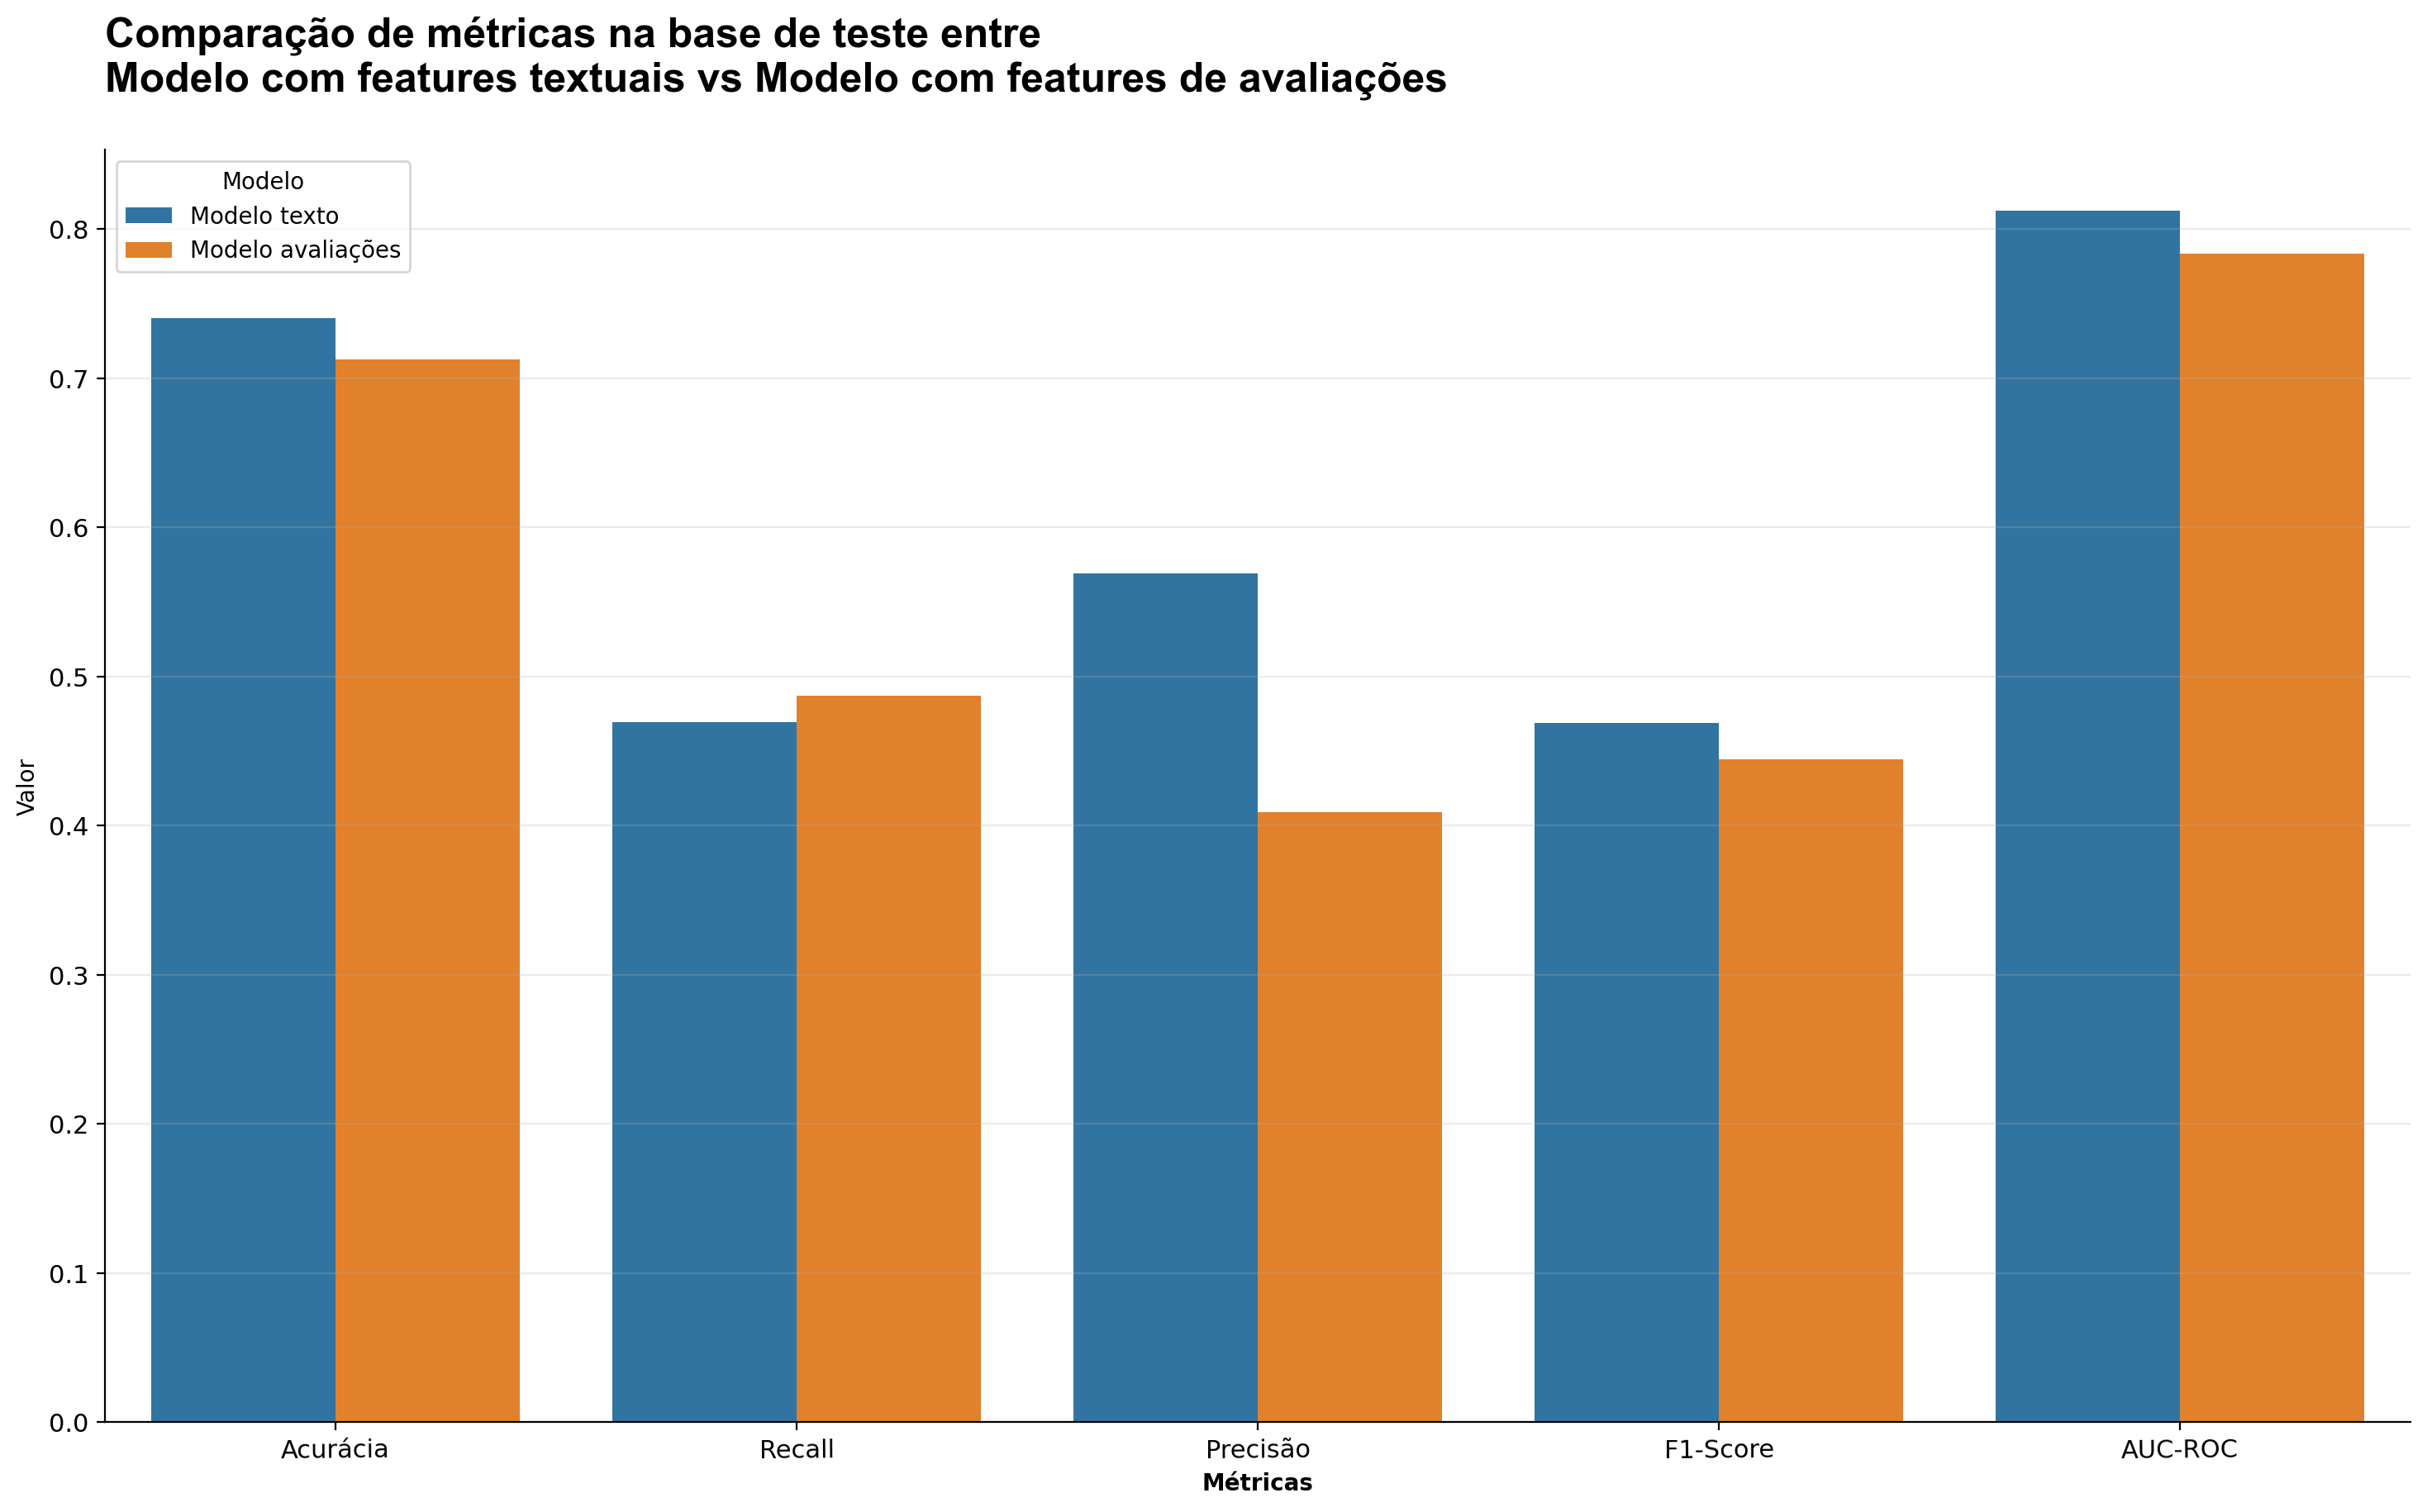

In [48]:
# Previsões
y_pred1 = mod1_predict
y_pred2 = mod2_predict

# Acurácia
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test2, y_pred2)

# Recall
recall1 = recall_score(y_test, y_pred1, average='macro')
recall2 = recall_score(y_test, y_pred2, average='macro')

# Precisão
precision1 = precision_score(y_test, y_pred1, average='macro')
precision2 = precision_score(y_test2, y_pred2, average='macro')

# F1-Score (macro)
f1_1 = f1_score(y_test, y_pred1, average='macro')
f1_2 = f1_score(y_test2, y_pred2, average='macro')

# Para calcular o AUC-ROC para múltiplas classes, binarizar as labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_test_bin2 = label_binarize(y_test2, classes=[0, 1, 2])

# Prever probabilidades para o AUC-ROC
y_prob1 = opt_mod1.predict_proba(X_test)
y_prob2 = opt_mod2.predict_proba(X_test2)

# AUC-ROC
auc_roc1 = roc_auc_score(y_test_bin, y_prob1, average='macro', multi_class='ovo')
auc_roc2 = roc_auc_score(y_test_bin2, y_prob2, average='macro', multi_class='ovo')

# Colocar as métricas em um dicionário para plotar
metrics = {
    'Métrica': ['Acurácia', 'Recall', 'Precisão', 'F1-Score', 'AUC-ROC', 'Acurácia', 'Recall', 'Precisão', 'F1-Score', 'AUC-ROC'],
    'Valor': [accuracy1, recall1, precision1, f1_1, auc_roc1, accuracy2, recall2, precision2, f1_2, auc_roc2],
    'Modelo': ['Modelo texto'] * 5 + ['Modelo avaliações'] * 5
}

# Convertendo dicionário de métricas em DataFrame para visualização
metrics_df = pd.DataFrame(metrics)

# Plotando as métricas
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=metrics_df, palette=['#1f77b4', '#ff7f0e'], ax = ax)
ax.set_title('Comparação de métricas na base de teste entre\nModelo com features textuais vs Modelo com features de avaliações\n', loc = 'left', fontsize = 18, fontfamily = 'arial', fontweight = 'bold')
ax.set_ylabel('Valor')
ax.set_xlabel('Métricas', fontweight = 'bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True, axis = 'y', alpha = .25)
ax.xaxis.set_tick_params(labelsize = 11, labelrotation = .5)
ax.yaxis.set_tick_params(labelsize = 11)

O gráfico acima deixa claro que **o modelo que usou as informações textuais de** ``Review`` **e** ``Review_Title`` **conseguiu um melhor desempenho com os dados de teste em todas as métricas de avaliação**.  
E portanto, é o melhor modelo para classificação de sentimentos com os dados trabalhados.

In [49]:
# Exportando melhor modelo
joblib.dump(opt_mod1, os.path.join(model_path, 'model.pkl'))

['../model\\model.pkl']